In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Dependencies and Setup
import time
from pprint import pprint
import requests
from datetime import date, timedelta, datetime
import json
from pprint import pprint
from tqdm import tqdm
from tqdm import tqdm_notebook
# sqlite Dependencies
# ----------------------------------
# Imports the method used for connecting to DBs
from sqlalchemy import create_engine
# Allow us to declare column types
from sqlalchemy import Column, Integer, String, Text, DateTime, Float, Boolean, ForeignKey
from sqlalchemy.orm import relationship
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session

In [9]:
from nba_api.stats.endpoints import playercareerstats, drafthistory, commonplayerinfo, playerawards

In [10]:
# Not used
# cumestatsplayer,draftcombinedrillresults,playerdashboardbyteamperformance, leagueleaders, leaguedashplayerstats, draftcombinenonstationaryshooting, draftcombinestats, commonallplayers,

-------------

# Open Saved JSON

In [11]:
with open('./_players_all_data.json') as json_file:
    data = json.load(json_file)

In [32]:
#  Player positions
player_positions = pd.read_csv('../../datasets/nba_positions_no_team.csv') 

In [33]:
five_year_all_players = pd.read_json(data)
twenty_years_all_players_raw = five_year_all_players[five_year_all_players['SEASON_ID'] > '1999-00']
twenty_years_all_players_raw = twenty_years_all_players_raw.join(player_positions.set_index('PLAYER_NAME'), on='PLAYER_NAME')
twenty_years_all_players_raw = twenty_years_all_players_raw.dropna(how='any').sort_values(by=['PTS'], ascending=False).drop_duplicates( keep='first').reset_index(drop=True)
twenty_years_all_players_raw['PPGP'] = round(twenty_years_all_players_raw['PTS'] / twenty_years_all_players_raw['GP'], 2)
twenty_years_all_players = twenty_years_all_players_raw.copy()
twenty_years_all_players

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,AST,STL,BLK,TOV,PF,PTS,YIL,PLAYER_NAME,POSITION,PPGP
0,2544,2005-06,0,1610612739,CLE,21,79,79.0,3361.0,875,...,521,123.0,66.0,260.0,181,2478,3,LeBron James,SF,31.37
1,201142,2009-10,0,1610612760,OKC,21,82,82.0,3239.0,794,...,231,112.0,84.0,271.0,171,2472,3,Kevin Durant,SF,30.15
2,2240,2005-06,0,1610612764,WAS,24,80,80.0,3384.0,746,...,484,161.0,25.0,297.0,286,2346,5,Gilbert Arenas,PG,29.32
3,2544,2007-08,0,1610612739,CLE,23,75,74.0,3027.0,794,...,539,138.0,81.0,255.0,165,2250,5,LeBron James,SF,30.00
4,947,2000-01,0,1610612755,PHI,26,71,71.0,2976.0,762,...,325,178.0,20.0,237.0,147,2207,5,Allen Iverson,SG,31.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5322,202918,2017-18,0,1610612738,BOS,30,2,0.0,8.0,0,...,0,1.0,0.0,0.0,1,0,2,Xavier Silas,G,0.00
5323,204067,2017-18,0,1610612738,BOS,26,2,0.0,6.0,0,...,0,1.0,0.0,0.0,0,0,3,Jarell Eddie,F,0.00
5324,2062,2002-03,0,1610612744,GSW,25,2,0.0,9.0,0,...,2,1.0,0.0,1.0,0,0,3,A.J. Guyton,G,0.00
5325,204067,2017-18,0,1610612741,CHI,26,1,0.0,3.0,0,...,0,0.0,0.0,0.0,0,0,3,Jarell Eddie,F,0.00


In [34]:
# Assign the data to X and y

X = twenty_years_all_players[["MIN", "GP"]]
y = twenty_years_all_players["PTS"].values.reshape(-1, 1)
print(X.shape, y.shape)

(5327, 2) (5327, 1)


In [35]:
# Use train_test_split to create training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create the model using LinearRegression

from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [36]:
# Fit the model to the training data and calculate the scores for the training and testing data

model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)



print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.897967846399868
Testing Score: 0.9121004829830615


Text(0.5, 1.0, 'Residual Plot')

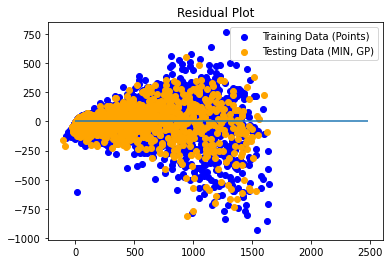

In [37]:
# Plot the Residuals for the Training and Testing data

# Use `model.predict()` to get a prediction array from X_train and X_test
y_train_prediction = model.predict(X_train)
y_test_prediction = model.predict(X_test)

# Plot the residual
plt.scatter(y_train_prediction, y_train_prediction - y_train, c="blue", label="Training Data (Points)")
plt.scatter(y_test_prediction, y_test_prediction - y_test, c="orange", label="Testing Data (MIN, GP)")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")


--------------------------

In [43]:
# twenty_years_all_players

In [44]:
ml_test = twenty_years_all_players.drop(columns=['PLAYER_NAME','TEAM_ABBREVIATION','SEASON_ID'])

In [45]:
ml_test2 = pd.get_dummies(ml_test)
ml_test2.head()

,PLAYER_ID,LEAGUE_ID,TEAM_ID,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,...,PPGP,POSITION_ C,POSITION_ F,POSITION_ G,POSITION_ GF,POSITION_ NA,POSITION_ PF,POSITION_ PG,POSITION_ SF,POSITION_ SG
0,2544,0,1610612739,21,79,79.0,3361.0,875,1823,0.480,...,31.37,0,0,0,0,0,0,0,1,0
1,201142,0,1610612760,21,82,82.0,3239.0,794,1668,0.476,...,30.15,0,0,0,0,0,0,0,1,0
2,2240,0,1610612764,24,80,80.0,3384.0,746,1668,0.447,...,29.32,0,0,0,0,0,0,1,0,0
3,2544,0,1610612739,23,75,74.0,3027.0,794,1642,0.484,...,30.00,0,0,0,0,0,0,0,1,0
4,947,0,1610612755,26,71,71.0,2976.0,762,1813,0.420,...,31.08,0,0,0,0,0,0,0,0,1


OREB: Offensive Rebounds  
DREB: Defensive Rebounds   
REB: Rebounds  
AST: Assists  
TOV: Turnovers  
STL: Steals  
BLK: Blocks  

In [46]:
X = twenty_years_all_players[["MIN", "GP"]]
# Select the 'FEV' column for y, and then use values.reshape() to reshape it to a 2d array
y = twenty_years_all_players["PPGP"].values.reshape(-1, 1)

In [47]:
# Split the data into training and testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [48]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)


In [49]:
# Transform the training and testing data using the X_scaler and y_scaler models

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [50]:
# Create a LinearRegression model and fit it to the scaled training data

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)


LinearRegression()

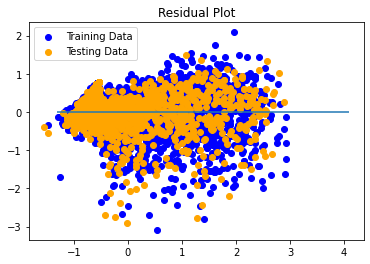

In [51]:
# Make predictions using a fitted model
# Plot the difference between the model predicted values and actual y values, versus the model predicted values
# Hint: You can predict values of X training and testing data using the model.predict() method on a fitted model
y_test_prediction = model.predict(X_test_scaled)
y_train_prediction = model.predict(X_train_scaled)


plt.scatter(y_train_prediction, y_train_prediction - y_train_scaled, c="blue", label="Training Data")
plt.scatter(y_test_prediction, y_test_prediction - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

--------

### Mean Square Error

In [52]:
# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2

from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test_scaled, y_test_prediction)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.2544318207940628, R2: 0.7698238497482489


In [53]:
# LASSO model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=.01)

lasso.fit(X_train_scaled, y_train_scaled)

predictions = lasso.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = lasso.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.2563257276311836, R2: 0.768110494149317


In [54]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01)
ridge.fit(X_train_scaled, y_train_scaled)

predictions = ridge.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = ridge.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.2544318999751175, R2: 0.7698237781157373


In [55]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01)
elasticnet.fit(X_train_scaled, y_train_scaled)

predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = elasticnet.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")


MSE: 0.2562312632741197, R2: 0.7681959529648736


---------------

In [ ]:
X = twenty_years_all_players[["MIN", "YIL"]]
y = twenty_years_all_players["PTS"].values.reshape(-1, 1)
print(X.shape, y.shape)

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=2, random_state=42)

print(f"Labels: {y[:10]}")
print(f"Data: {X[:10]}")

In [ ]:
# Visualizing both classes
plt.scatter(X[:, 0], X[:, 1], c=y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

In [ ]:
classifier.fit(X_train, y_train)
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

In [ ]:
### DF for each year. decending
first_year = twenty_years_all_players[twenty_years_all_players['YIL'] == 1]
second_year = twenty_years_all_players[twenty_years_all_players['YIL'] == 2]
third_year = twenty_years_all_players[twenty_years_all_players['YIL'] == 3]
fourth_year = twenty_years_all_players[twenty_years_all_players['YIL'] == 4]
fifth_year = twenty_years_all_players[twenty_years_all_players['YIL'] == 5]

## Plot YIL to Total Points

First Year Total Points per Position

In [ ]:
import plotly.express as px

fig = px.scatter(twenty_years_all_players, x="MIN", y="PTS", log_x=True, hover_name="PLAYER_NAME", hover_data=["PTS", 'SEASON_ID', 'TEAM_ABBREVIATION'], color="YIL",
                 size='PTS', title="First Year Total Points per Position")
fig.show()

Second Year Total Points per Position

In [ ]:
import plotly.express as px

fig = px.scatter(second_year, x="PTS", y="POSITION", log_x=True, hover_name="PLAYER_NAME", hover_data=["PTS"], color="PTS",
                 size='PTS', title="Second Year Total Points per Position")
fig.show()

In [ ]:
## Remove NaN . Will sway values greatly
# first_year = first_year.dropna().sort_values(by=['PTS'], ascending=False).drop_duplicates( keep='first')
# first_year

In [ ]:
test = list(first_year.columns.values)

In [ ]:
fig = px.scatter_polar(first_year, r="PTS", theta="POSITION", color="PTS",
                    template="plotly_dark", title="First Year Total Points per Position")
fig.show()

In [ ]:
twenty_years_all_players[['YIL','PTS','STL','BLK','REB','MIN','AST','TOV']].columns

In [ ]:
import plotly.express as px
df = px.data.stocks()
fig = px.line(twenty_years_all_players, x="MIN", y=twenty_years_all_players[['YIL','PTS','STL','BLK','REB','MIN','AST','TOV']].columns,
              hover_data={"PLAYER_NAME"},
              title='custom tick labels',
             color="YIL")
# fig.update_xaxes(
#     dtick="M1",
#     tickformat="%b\n%Y")
fig.show()

https://plotly.com/python/polar-chart/

In [ ]:
# import plotly.express as px
# df = px.data.wind()
# fig = px.line_polar(twenty_years_all_players, r="PTS", theta="POSITION", color="YIL", line_close=True,
#                     color_discrete_sequence=px.colors.sequential.Plasma_r,
#                     template="plotly_dark",)
# fig.show()

In [ ]:
# df = px.data.wind()
# df